In [6]:
from eyring_model import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

# some constants
kB = 1.380649 * 10**-23    # Boltzmann (m^2 kg / s^2 K)
h = 6.62607 * 10**-34      # Planck (m^2 kg / s)
R = 1.9858775 * 10**-3     # universal gas (kcal / mol K)

In [7]:
# input parameters
avg_T = 300
dH_barrier = 3.5
dS_barrier = -9/avg_T
dH_sigma = dH_barrier/3
dS_sigma = -dS_barrier/3
n_paths = 22000
area = 1e8
lam = 10
n_jumps = 200
delta = lam*n_jumps

In [8]:
# initialize arrays
T = np.array([250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350])
P_norm = np.zeros(len(T))
P_exp = np.zeros(len(T))

In [9]:
# run Eyring model for each temperature with normally distributed barriers
dist = 'norm'
params = {'mu' : np.array([dH_barrier, dS_barrier]),
          'cov': np.array([[dH_sigma**2, 0],
                           [0, dS_sigma**2]])}


for i, temp in tqdm(enumerate(T)):
    model = EyringModel(T=temp, A=area)
    for n in range(n_paths):
        model.add_Path(n_jumps=n_jumps, lam=lam)
        model.paths[n].generate_membrane_barriers(dist=dist, multi=True, dist_params=params)
        
    P_norm[i] = model.calculate_permeability() / 60 / 60 / 1000 * 10**9 * 10

0it [00:00, ?it/s]

11it [01:11,  6.47s/it]


In [10]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_norm), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 5.01 +/- 0.02 kcal/mol
Arrhenius prefactor, ln(A): -0.43 +/- 0.04 A/s
Prediction for 305 K: -8.70


In [11]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_norm/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.42 +/- 0.03 kcal/mol
Arrhenius prefactor, ln(A): -7.13 +/- 0.05 A/s
Prediction for 305 K: -14.43


In [12]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_norm*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.42 +/- 0.03 kcal/mol
Arrhenius prefactor, ln(A): -27.89 +/- 0.05 A/s
Prediction for 305 K: -35.19


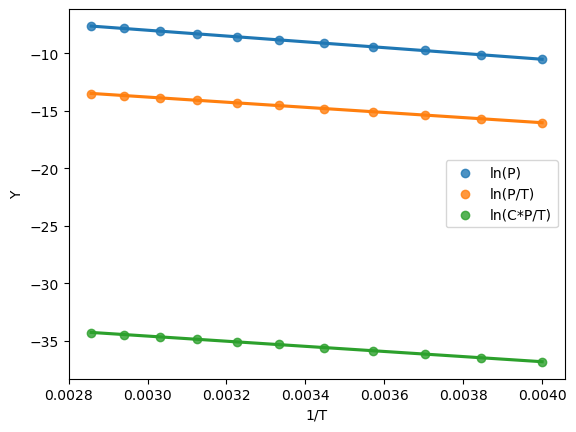

In [13]:
# plot linear fits
df = pd.DataFrame()
df['1/T'] = 1/T
df['ln(P)'] = np.log(P_norm)
df['ln(P/T)'] = np.log(P_norm/T)
df['ln(CP/T)'] = np.log(P_norm*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)')
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)')
sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [14]:
# run Eyring model for each temperature with exponentially distributed barriers
dist = 'exp'
params = {'beta'  : np.array([dH_barrier, dS_barrier])}

for i, temp in tqdm(enumerate(T)):
    model = EyringModel(T=temp, A=area)
    for n in range(n_paths):
        model.add_Path(n_jumps=n_jumps, lam=lam)
        model.paths[n].generate_membrane_barriers(dist=dist, multi=True, dist_params=params)
        
    P_exp[i] = model.calculate_permeability() / 60 / 60 / 1000 * 10**9 * 10

11it [00:39,  3.60s/it]


In [15]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_exp), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.45 +/- 3.21 kcal/mol
Arrhenius prefactor, ln(A): -28.15 +/- 5.49 A/s
Prediction for 305 K: -35.50


In [16]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_exp/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.87 +/- 3.22 kcal/mol
Arrhenius prefactor, ln(A): -34.84 +/- 5.49 A/s
Prediction for 305 K: -41.22


In [17]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_exp*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.87 +/- 3.22 kcal/mol
Arrhenius prefactor, ln(A): -55.60 +/- 5.49 A/s
Prediction for 305 K: -61.99


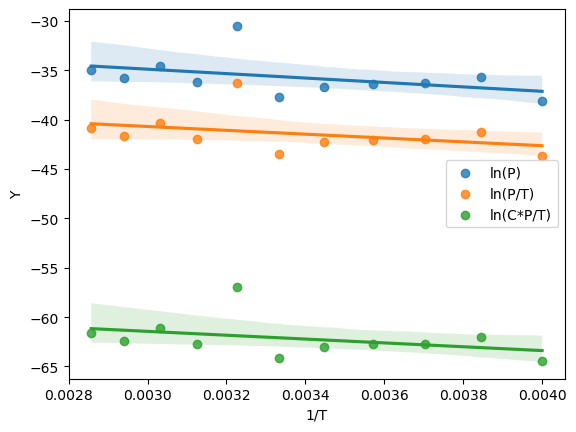

In [18]:
# plot linear fits
df = pd.DataFrame()
df['1/T'] = 1/T
df['ln(P)'] = np.log(P_exp)
df['ln(P/T)'] = np.log(P_exp/T)
df['ln(CP/T)'] = np.log(P_exp*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)')
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)')
sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [32]:
# now the same analysis for the experimental data
df = pd.read_excel('../P_vs_T_results.xlsx')
df = df[df['system'] == 'NaCl (NF270)']
T = df['T (K)']
P_experiment = df['B (m/sec)']

In [38]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_experiment), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results1.summary())

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.02 +/- 0.76 kcal/mol
Arrhenius prefactor, ln(A): -3.59 +/- 1.28 A/s
Prediction for 305 K: -10.24
                            OLS Regression Results                            
Dep. Variable:              B (m/sec)   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     28.03
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           7.27e-05
Time:                        14:03:50   Log-Likelihood:                 5.9381
No. Observations:                  18   AIC:                            -7.876
Df Residuals:                      16   BIC:                            -6.096
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|    

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [39]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_experiment/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results2.summary())

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.43 +/- 0.76 kcal/mol
Arrhenius prefactor, ln(A): -10.29 +/- 1.29 A/s
Prediction for 305 K: -15.96
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     20.37
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           0.000354
Time:                        14:04:40   Log-Likelihood:                 5.9331
No. Observations:                  18   AIC:                            -7.866
Df Residuals:                      16   BIC:                            -6.085
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t| 

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [36]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_experiment*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.43 +/- 0.76 kcal/mol
Arrhenius prefactor, ln(A): -31.06 +/- 1.29 A/s
Prediction for 305 K: -36.72


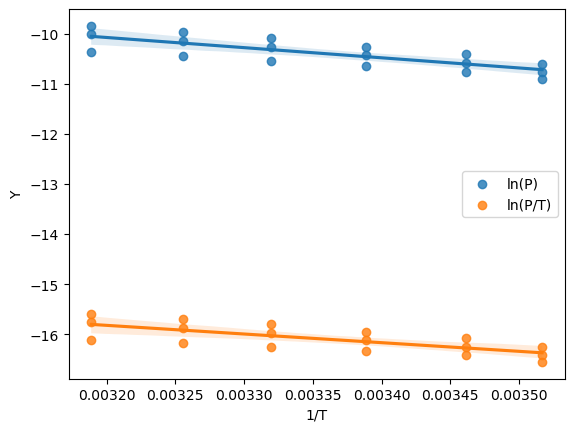

In [37]:
# plot the linear fits
df['1/T'] = 1/df['T (K)']
df['ln(P)'] = np.log(P_experiment)
df['ln(P/T)'] = np.log(P_experiment/T)
df['ln(CP/T)'] = np.log(P_experiment*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)', ci=95)
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)', ci=95)
# sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [48]:
print(f'Sum of squared residuals for ln(P) vs 1/T: {results1.ssr}')
print(f'Sum of squared residuals for ln(P/T) vs 1/T: {results2.ssr}')

Sum of squared residuals for ln(P) vs 1/T: 0.5448210209390335
Sum of squared residuals for ln(P/T) vs 1/T: 0.5451251527821924
